In [2]:
# Import Libraries
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import tqdm
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split

c:\Users\rifat\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Specify transforms using torchvision.transforms as transforms
# library
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Load in each dataset and apply transformations using
# the torchvision.datasets as datasets library
train_set = datasets.ImageFolder("D:/learn_django_v3/x-ray/chest_xray/train/", transform = transformations)
val_set = datasets.ImageFolder("D:/learn_django_v3/x-ray/chest_xray/val/", transform = transformations)

In [5]:

# Specify transforms using torchvision.transforms as transforms
# library
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load in each dataset and apply transformations using
# the torchvision.datasets as datasets library
train_set = datasets.ImageFolder("D:/learn_django_v3/x-ray/chest_xray/train/", transform = transformations)
val_set = datasets.ImageFolder("D:/learn_django_v3/x-ray/chest_xray/val/", transform = transformations)
# Put into a Dataloader using torch library
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size =128, shuffle=True)
# Get pretrained model using torchvision.models as models library
model = models.resnet18(pretrained=True)
# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False


    


c:\Users\rifat\miniconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rifat\miniconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Get pretrained model using torchvision.models as models library
model = models.resnet18(pretrained=True)
# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

c:\Users\rifat\miniconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rifat\miniconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Create new classifier for model using torch.nn as nn library
classifier_input = model.fc.in_features
num_labels = 2
classifier = nn.Sequential(nn.Linear(classifier_input, 100),
                            nn.ReLU(),
                            nn.Linear(100, 512),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(512, 128),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(128, 64),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(64, num_labels),
                            nn.LogSoftmax(dim=1))
model.fc = classifier
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

11,353,574 total parameters.
177,062 training parameters.


In [14]:

# Define Optimizer and Loss Function
writer = SummaryWriter()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)
def objective(trial):
    # Sample hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 3000, 20000, log=True)
    # Define Optimizer and Loss Function
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()
    # Train the model
    epoch_loss=0
    with tqdm.tqdm(total=len(train_loader)) as pbar:
        for batch_idx, (data, target) in enumerate(train_loader):
            # Send data and target to device
            data, target = data.to(device), target.to(device)
            # Clear the gradients
            optimizer.zero_grad()
            # Get model predictions
            output = model(data.to(device))
            # Calculate loss
            loss = criterion(output, target)
            # Backpropagation
            loss.backward()
            # Update model parameters
            optimizer.step()
            # Update tqdm
            pbar.update(1)
            epoch_loss += loss.item()
            # Record loss
            writer.add_scalar('train_loss', loss.item(), global_step=batch_idx)
    # Calculate average loss
    avg_loss = epoch_loss / len(train_loader)
    writer.add_scalar('avg_train_loss', avg_loss)
    print(f'Average loss at epoch  {avg_loss}')
    return avg_loss

study = optuna.create_study(direction='minimize')

# Start hyperparameter optimization
study.optimize(objective, n_trials=30)
# Get the best hyperparameters
best_params = study.best_params
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Learning Rate: {best_lr}")
print(f"Batch Size: {best_batch_size}")

    



[I 2023-08-26 18:00:40,410] A new study created in memory with name: no-name-bfa99531-a44f-49b8-a99f-e804663f7f12
100%|██████████| 41/41 [01:28<00:00,  2.15s/it]
[I 2023-08-26 18:02:08,524] Trial 0 finished with value: 0.14363773694125617 and parameters: {'lr': 0.0024878646890129997, 'batch_size': 3674}. Best is trial 0 with value: 0.14363773694125617.


Average loss at epoch  0.14363773694125617


100%|██████████| 41/41 [01:26<00:00,  2.12s/it]
[I 2023-08-26 18:03:35,479] Trial 1 finished with value: 0.1900747764583041 and parameters: {'lr': 0.0033467175692068326, 'batch_size': 5571}. Best is trial 0 with value: 0.14363773694125617.


Average loss at epoch  0.1900747764583041


100%|██████████| 41/41 [01:27<00:00,  2.12s/it]
[I 2023-08-26 18:05:02,585] Trial 2 finished with value: 0.10638459508375424 and parameters: {'lr': 0.00013717889002523099, 'batch_size': 12415}. Best is trial 2 with value: 0.10638459508375424.


Average loss at epoch  0.10638459508375424


100%|██████████| 41/41 [01:28<00:00,  2.15s/it]
[I 2023-08-26 18:06:30,880] Trial 3 finished with value: 0.12449009171346338 and parameters: {'lr': 0.0017273560756608506, 'batch_size': 4159}. Best is trial 2 with value: 0.10638459508375424.


Average loss at epoch  0.12449009171346338


100%|██████████| 41/41 [01:29<00:00,  2.19s/it]
[I 2023-08-26 18:08:00,540] Trial 4 finished with value: 0.1598266920120251 and parameters: {'lr': 0.0028696253864464727, 'batch_size': 5394}. Best is trial 2 with value: 0.10638459508375424.


Average loss at epoch  0.1598266920120251


100%|██████████| 41/41 [01:30<00:00,  2.21s/it]
[I 2023-08-26 18:09:31,217] Trial 5 finished with value: 0.10297688723700803 and parameters: {'lr': 0.00020342277430713269, 'batch_size': 5162}. Best is trial 5 with value: 0.10297688723700803.


Average loss at epoch  0.10297688723700803


100%|██████████| 41/41 [01:29<00:00,  2.19s/it]
[I 2023-08-26 18:11:00,868] Trial 6 finished with value: 0.09464905692673312 and parameters: {'lr': 0.00012093793880990866, 'batch_size': 3534}. Best is trial 6 with value: 0.09464905692673312.


Average loss at epoch  0.09464905692673312


100%|██████████| 41/41 [01:28<00:00,  2.17s/it]
[I 2023-08-26 18:12:29,702] Trial 7 finished with value: 0.10826746765069845 and parameters: {'lr': 0.0010666716670755996, 'batch_size': 17227}. Best is trial 6 with value: 0.09464905692673312.


Average loss at epoch  0.10826746765069845


100%|██████████| 41/41 [01:29<00:00,  2.18s/it]
[I 2023-08-26 18:13:59,130] Trial 8 finished with value: 0.3064705713129625 and parameters: {'lr': 0.007571013168397345, 'batch_size': 5308}. Best is trial 6 with value: 0.09464905692673312.


Average loss at epoch  0.3064705713129625


100%|██████████| 41/41 [01:27<00:00,  2.14s/it]
[I 2023-08-26 18:15:26,976] Trial 9 finished with value: 0.15851829618942448 and parameters: {'lr': 0.003723775439125651, 'batch_size': 3604}. Best is trial 6 with value: 0.09464905692673312.


Average loss at epoch  0.15851829618942448


100%|██████████| 41/41 [01:29<00:00,  2.19s/it]
[I 2023-08-26 18:16:56,581] Trial 10 finished with value: 0.10156762863441211 and parameters: {'lr': 0.00038903068316596586, 'batch_size': 8659}. Best is trial 6 with value: 0.09464905692673312.


Average loss at epoch  0.10156762863441211


100%|██████████| 41/41 [01:29<00:00,  2.18s/it]
[I 2023-08-26 18:18:26,007] Trial 11 finished with value: 0.09916964591276355 and parameters: {'lr': 0.0003390416864679311, 'batch_size': 8014}. Best is trial 6 with value: 0.09464905692673312.


Average loss at epoch  0.09916964591276355


100%|██████████| 41/41 [01:31<00:00,  2.24s/it]
[I 2023-08-26 18:19:57,782] Trial 12 finished with value: 0.1060556329605056 and parameters: {'lr': 0.0004131985373594695, 'batch_size': 3029}. Best is trial 6 with value: 0.09464905692673312.


Average loss at epoch  0.1060556329605056


100%|██████████| 41/41 [01:31<00:00,  2.23s/it]
[I 2023-08-26 18:21:29,333] Trial 13 finished with value: 0.09299639594264147 and parameters: {'lr': 0.00010716584553243435, 'batch_size': 7825}. Best is trial 13 with value: 0.09299639594264147.


Average loss at epoch  0.09299639594264147


100%|██████████| 41/41 [01:32<00:00,  2.24s/it]
[I 2023-08-26 18:23:01,387] Trial 14 finished with value: 0.09350316962454377 and parameters: {'lr': 0.00010276653215019851, 'batch_size': 7145}. Best is trial 13 with value: 0.09299639594264147.


Average loss at epoch  0.09350316962454377


100%|██████████| 41/41 [01:32<00:00,  2.25s/it]
[I 2023-08-26 18:24:33,622] Trial 15 finished with value: 0.09283358294789384 and parameters: {'lr': 0.00011329437099290282, 'batch_size': 10106}. Best is trial 15 with value: 0.09283358294789384.


Average loss at epoch  0.09283358294789384


100%|██████████| 41/41 [01:32<00:00,  2.27s/it]
[I 2023-08-26 18:26:06,552] Trial 16 finished with value: 0.08807113984736001 and parameters: {'lr': 0.00021367223615921426, 'batch_size': 10311}. Best is trial 16 with value: 0.08807113984736001.


Average loss at epoch  0.08807113984736001


 24%|██▍       | 10/41 [00:23<01:13,  2.38s/it]
[W 2023-08-26 18:26:30,397] Trial 17 failed with parameters: {'lr': 0.0002350044590967715, 'batch_size': 10911} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\rifat\miniconda3\envs\tf\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\rifat\AppData\Local\Temp\ipykernel_18824\2151107223.py", line 30, in objective
    epoch_loss += loss.item()
KeyboardInterrupt
[W 2023-08-26 18:26:30,397] Trial 17 failed with value None.


KeyboardInterrupt: 

In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
# Train model
def train(epoch):
    model.train()
    tr_loss = 0
    # Iterate over train loader
    for batch_idx, (data, target) in enumerate(train_loader):
        # Zero out gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculate loss
        loss = loss_fn(output, target)
        # Backward pass
        loss.backward()
        # Update parameters
        optimizer.step()
        tr_loss += loss.item()
        if batch_idx % 50 == 0:
            print('Training loss after {} batches is {}'.format(batch_idx, loss.item()))
    print('Training loss after {} epoch is {}'.format(epoch, tr_loss / batch_idx))


In [ ]:
from tqdm import tqdm  # Import tqdm for progress bar

# Create a SummaryWriter to log data for TensorBoard
writer = SummaryWriter()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def objective(trial):
    # Sample hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 3000, 20000, log=True)

    # Model building: 17 input features and 1 output feature
    model = nn.Sequential(
        nn.Linear(17, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )

    # Move model to the specified device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load('model_epoch9.pt'))
    model.to(device)

    # Define loss function and optimizer
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_dataset = custom_csv_dataset(train_df)

    # Define a new DataLoader with the suggested batch size
    new_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    epoch_loss = 0.0  # Initialize epoch loss

    # Create tqdm progress bar for training batches
    with tqdm(total=len(new_train_loader), unit='batch') as pbar:
        for batch_idx, (train_data, target_data) in enumerate(new_train_loader):

            train_data, target_data = train_data.to(device), target_data.to(device)

            # Forward pass
            pred = model(train_data)
            pred = pred.view(-1)  # Flattening the predictions to match target_data shape

            # Reshape target_data to match pred shape
            target_data = target_data.view_as(pred)

            loss = loss_function(pred, target_data)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Accumulate batch loss

            # Update tqdm progress bar
            pbar.set_postfix({'Loss': loss.item()})
            pbar.update(1)

            # Log loss for TensorBoard
            writer.add_scalar('Batch Loss', loss.item(), batch_idx)

    # Calculate average epoch loss
    average_epoch_loss = epoch_loss / len(new_train_loader)

    # Log average epoch loss for TensorBoard
    writer.add_scalar('Epoch Average Loss', average_epoch_loss)

    print(f'Average Loss: {average_epoch_loss:.4f}')

    return average_epoch_loss

# Create an Optuna study object
study = optuna.create_study(direction='minimize')

# Start hyperparameter optimization
study.optimize(objective, n_trials=30)
# Get the best hyperparameters
best_params = study.best_params
best_lr = best_params['lr']
best_batch_size = best_params['batch_size']

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Learning Rate: {best_lr}")
print(f"Batch Size: {best_batch_size}")



In [46]:
# Create new classifier for model using torch.nn as nn library
classifier_input = model.fc.in_features
num_labels = 2
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))
model.fc = classifier
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')
# Define Optimizer and Loss Function



12,227,650 total parameters.
1,051,138 training parameters.


In [ ]:
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()
# Train model
def train(epoch):
    model.train()
    tr_loss = 0
    # Iterate over train loader
    for batch_idx, (data, target) in enumerate(train_loader):
        # Zero out gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculate loss
        loss = loss_fn(output, target)
        # Backward pass
        loss.backward()
        # Update parameters
        optimizer.step()
        tr_loss += loss.item()
        if batch_idx % 50 == 0:
            print('Training loss after {} batches is {}'.format(batch_idx, loss.item()))
    print('Training loss after {} epoch is {}'.format(epoch, tr_loss / batch_idx))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 224, 224]) torch.Size([128])
tensor(0)


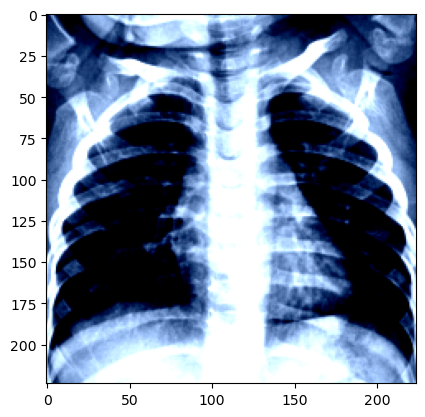

In [35]:
sample = next(iter(train_loader))
image, label = sample
print(image.shape, label.shape)
print(label[0])
plt.imshow(image[0].permute(1, 2, 0))


In [33]:
label[0]

tensor(1)

In [14]:
import torch
from torchvision import datasets, transforms

# # Define the paths to your image directories
# normal_dir = 'D:/learn_django_v3/x-ray/chest_xray/chest_xray/train/NORMAL'
# pneumonia_dir = 'D:/learn_django_v3/x-ray/chest_xray/chest_xray/train/PNEUMONIA'

root = r'D:\learn_django_v3\x-ray\chest_xray\train'
normal_dir = root + '/NORMAL'
pneumonia_dir = root + '/PNEUMONIA'

# Load the images
normal_data = datasets.ImageFolder(normal_dir)
pneumonia_data = datasets.ImageFolder(pneumonia_dir)

# Obtain the number of images in each category
normal_len = len(normal_data)


FileNotFoundError: Couldn't find any class folder in D:\learn_django_v3\x-ray\chest_xray\train/NORMAL.

In [4]:
pneumonia_dir

'D:\\learn_django_v3\\x-ray\\chest_xray\\chest_xray\\train\\PNEUMONIA'

In [7]:
# Define data transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image values
])

# Create datasets using ImageFolder
normal_dataset = datasets.ImageFolder(normal_dir, transform=transform)
pneumonia_dataset = datasets.ImageFolder(pneumonia_dir, transform=transform)




FileNotFoundError: Couldn't find any class folder in D:/learn_django_v3/x-ray/chest_xray/chest_xray/train/NORMAL.

In [ ]:
# Create data loaders to iterate over batches of data
batch_size = 32  # You can adjust this based on your needs
normal_loader = torch.utils.data.DataLoader(normal_dataset, batch_size=batch_size, shuffle=True)
pneumonia_loader = torch.utils.data.DataLoader(pneumonia_dataset, batch_size=batch_size, shuffle=True)